In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data1 =pd.read_csv("../input/solarpanelspower/PV_Elec_Gas2.csv")
data1.set_index("Unnamed: 0", drop=False, inplace=True)
print(data1.head())
print(data1.tail())
print('Length of data is: ' + str(len(data1)))

            Unnamed: 0  cum_power  Elec_kW  Gas_mxm
Unnamed: 0                                         
2011-10-26  2011-10-26        0.1     15.1      9.0
2011-10-27  2011-10-27       10.2      7.4      9.2
2011-10-28  2011-10-28       20.2      5.8      8.0
2011-10-29  2011-10-29       29.6      4.9      6.6
2011-10-30  2011-10-30       34.2     11.7      5.3
            Unnamed: 0  cum_power  Elec_kW  Gas_mxm
Unnamed: 0                                         
2019-11-16  2019-11-16    32231.0     12.0     15.0
2019-11-17  2019-11-17    32235.0     13.0     14.0
2019-11-18  2019-11-18    32238.0     13.0     14.0
2019-11-19  2019-11-19    32238.0     13.0     15.0
2019-11-20  2019-11-20    32244.0      9.0     16.0
Length of data is: 2948


In [3]:
data1.head(15)

,Unnamed: 0,cum_power,Elec_kW,Gas_mxm
Unnamed: 0,,,,
2011-10-26,2011-10-26,0.1,15.1,9.0
2011-10-27,2011-10-27,10.2,7.4,9.2
2011-10-28,2011-10-28,20.2,5.8,8.0
2011-10-29,2011-10-29,29.6,4.9,6.6
2011-10-30,2011-10-30,34.2,11.7,5.3
2011-10-31,2011-10-31,38.0,11.0,5.7
2011-11-01,2011-11-01,46.6,3.5,5.3
2011-11-02,2011-11-02,51.6,10.5,5.4
2011-11-03,2011-11-03,58.6,6.9,7.6


In [4]:
df= pd.read_csv("../input/solarpanelspower/PV_Elec_Gas2.csv", usecols= ['Unnamed: 0', 'Gas_mxm'])
df.set_index("Unnamed: 0", drop=False, inplace=True)
df= df.iloc[6: ]
df.head()

,Unnamed: 0,Gas_mxm
Unnamed: 0,,
2011-11-01,2011-11-01,5.3
2011-11-02,2011-11-02,5.4
2011-11-03,2011-11-03,7.6
2011-11-04,2011-11-04,5.5
2011-11-05,2011-11-05,5.2


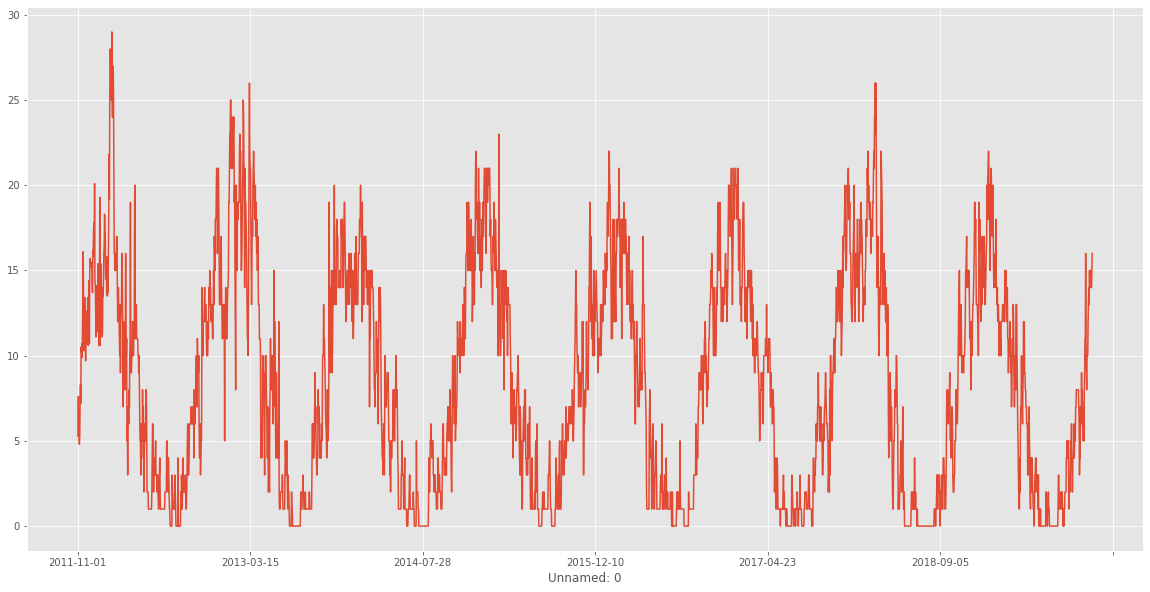

In [5]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
df.Gas_mxm.plot()

In [6]:
all_data = df['Gas_mxm'].values.astype(float)
all_data

array([ 5.3,  5.4,  7.6, ..., 14. , 15. , 16. ])

# Dividing Data into Train-Set and Test-set

In [7]:
test_data_size = 365

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [8]:
print(len(train_data))
print(len(test_data))

2577
365


# Normalizing the Train Data

Note:- The original data is not nirmalized as there is a chance to leak some information to test-set from train-set. Hence test-data is not normalized.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [10]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized= train_data_normalized.cuda()

Next, we will define a function named 'create_inout_sequences'. The function will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 'train_window'(365) items corresponding to the data for 365 days, the second tuple element will contain one item i.e. the number of passengers in the 356+1st day.

In [11]:
train_window = 365

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [12]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

# Creating LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [14]:
model = LSTM().cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


# Training

In [15]:
epochs = 1000

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = torch.zeros(1, 1, model.hidden_layer_size).cuda(), torch.zeros(1, 1, model.hidden_layer_size).cuda()

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i< 1000:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.02813717
epoch:   1 loss: 0.02103521
epoch:   2 loss: 0.01836902
epoch:   3 loss: 0.01412968
epoch:   4 loss: 0.01078468
epoch:   5 loss: 0.00887893
epoch:   6 loss: 0.00787543
epoch:   7 loss: 0.00733255
epoch:   8 loss: 0.00698167
epoch:   9 loss: 0.00666813
epoch:  10 loss: 0.00651304
epoch:  11 loss: 0.00627968
epoch:  12 loss: 0.00635981
epoch:  13 loss: 0.00659548
epoch:  14 loss: 0.00647661
epoch:  15 loss: 0.00659662
epoch:  16 loss: 0.00610050
epoch:  17 loss: 0.00668951
epoch:  18 loss: 0.00626410
epoch:  19 loss: 0.00637267
epoch:  20 loss: 0.00629412
epoch:  21 loss: 0.00519306
epoch:  22 loss: 0.00626738
epoch:  23 loss: 0.00542966
epoch:  24 loss: 0.00515712
epoch:  25 loss: 0.00539447
epoch:  26 loss: 0.00569166
epoch:  27 loss: 0.00603160
epoch:  28 loss: 0.00506497
epoch:  29 loss: 0.00468580
epoch:  30 loss: 0.00469604
epoch:  31 loss: 0.00500041
epoch:  32 loss: 0.00484454
epoch:  33 loss: 0.00405744
epoch:  34 loss: 0.00394348
epoch:  35 loss: 0.0

epoch: 293 loss: 0.00465013
epoch: 294 loss: 0.00006600
epoch: 295 loss: 0.01514939
epoch: 296 loss: 0.00122043
epoch: 297 loss: 0.00129824
epoch: 298 loss: 0.00131135
epoch: 299 loss: 0.00598585
epoch: 300 loss: 0.00053490
epoch: 301 loss: 0.01454260
epoch: 302 loss: 0.00569765
epoch: 303 loss: 0.00008392
epoch: 304 loss: 0.00012385
epoch: 305 loss: 0.00000002
epoch: 306 loss: 0.00008611
epoch: 307 loss: 0.00179044
epoch: 308 loss: 0.00072702
epoch: 309 loss: 0.00017955
epoch: 310 loss: 0.00495185
epoch: 311 loss: 0.00107451
epoch: 312 loss: 0.00850839
epoch: 313 loss: 0.00055931
epoch: 314 loss: 0.00047456
epoch: 315 loss: 0.00001473
epoch: 316 loss: 0.00083417
epoch: 317 loss: 0.00152390
epoch: 318 loss: 0.02300347
epoch: 319 loss: 0.00771111
epoch: 320 loss: 0.00280094
epoch: 321 loss: 0.00001061
epoch: 322 loss: 0.00094796
epoch: 323 loss: 0.00190220
epoch: 324 loss: 0.00099123
epoch: 325 loss: 0.00001962
epoch: 326 loss: 0.00051759
epoch: 327 loss: 0.00858022
epoch: 328 loss: 0.0

epoch: 586 loss: 0.00072666
epoch: 587 loss: 0.00072865
epoch: 588 loss: 0.00143304
epoch: 589 loss: 0.00006971
epoch: 590 loss: 0.00001892
epoch: 591 loss: 0.00212102
epoch: 592 loss: 0.00000199
epoch: 593 loss: 0.00108150
epoch: 594 loss: 0.00019528
epoch: 595 loss: 0.00002757
epoch: 596 loss: 0.00011310
epoch: 597 loss: 0.00108855
epoch: 598 loss: 0.00000605
epoch: 599 loss: 0.00033701
epoch: 600 loss: 0.00260537
epoch: 601 loss: 0.00006968
epoch: 602 loss: 0.00203823
epoch: 603 loss: 0.00339100
epoch: 604 loss: 0.00002079
epoch: 605 loss: 0.00000883
epoch: 606 loss: 0.00020271
epoch: 607 loss: 0.00022231
epoch: 608 loss: 0.00095964
epoch: 609 loss: 0.00041115
epoch: 610 loss: 0.00000002
epoch: 611 loss: 0.00011112
epoch: 612 loss: 0.00018448
epoch: 613 loss: 0.00000087
epoch: 614 loss: 0.00219455
epoch: 615 loss: 0.00005402
epoch: 616 loss: 0.00171561
epoch: 617 loss: 0.00042144
epoch: 618 loss: 0.00001200
epoch: 619 loss: 0.00001274
epoch: 620 loss: 0.00032619
epoch: 621 loss: 0.0

epoch: 879 loss: 0.01635628
epoch: 880 loss: 0.08321486
epoch: 881 loss: 0.01760892
epoch: 882 loss: 0.07576697
epoch: 883 loss: 0.02991283
epoch: 884 loss: 0.04400739
epoch: 885 loss: 0.06535733
epoch: 886 loss: 0.13250819
epoch: 887 loss: 0.05527473
epoch: 888 loss: 0.03012546
epoch: 889 loss: 0.00465195
epoch: 890 loss: 0.00282634
epoch: 891 loss: 0.03331187
epoch: 892 loss: 0.02011080
epoch: 893 loss: 0.03806457
epoch: 894 loss: 0.03854246
epoch: 895 loss: 0.03104728
epoch: 896 loss: 0.03781102
epoch: 897 loss: 0.02640469
epoch: 898 loss: 0.02786472
epoch: 899 loss: 0.01983144
epoch: 900 loss: 0.01978494
epoch: 901 loss: 0.03382766
epoch: 902 loss: 0.03183603
epoch: 903 loss: 0.03053751
epoch: 904 loss: 0.03067878
epoch: 905 loss: 0.03151331
epoch: 906 loss: 0.03418158
epoch: 907 loss: 0.03099586
epoch: 908 loss: 0.03001122
epoch: 909 loss: 0.03674556
epoch: 910 loss: 0.03716061
epoch: 911 loss: 0.04430837
epoch: 912 loss: 0.04115494
epoch: 913 loss: 0.03264641
epoch: 914 loss: 0.0

# Making Predictions

Now that our model is trained, we can start to make predictions. Since our test-set contains the data for the last 365 days and our model is trained to make predictions using a sequence length of 365. We will first filter the last 365 values from the training-set

In [16]:
fut_pred = 365

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.03448275849223137, -0.17241379618644714, -0.3103448152542114, -0.24137930572032928, -0.17241379618644714, -0.03448275849223137, 0.17241379618644714, -0.03448275849223137, 0.17241379618644714, 0.17241379618644714, 0.17241379618644714, 0.24137930572032928, 0.37931033968925476, 0.24137930572032928, 0.1034482792019844, 0.1034482792019844, 0.03448275849223137, 0.1034482792019844, 0.24137930572032928, 0.37931033968925476, 0.3103448152542114, 0.37931033968925476, 0.4482758641242981, 0.24137930572032928, 0.37931033968925476, 0.24137930572032928, 0.3103448152542114, 0.1034482792019844, 0.1034482792019844, 0.1034482792019844, -0.1034482792019844, -0.1034482792019844, -0.17241379618644714, -0.17241379618644714, -0.1034482792019844, 0.03448275849223137, 0.1034482792019844, 0.17241379618644714, 0.24137930572032928, 0.37931033968925476, -0.03448275849223137, -0.17241379618644714, 0.03448275849223137, 0.1034482792019844, -0.03448275849223137, 0.03448275849223137, -0.03448275849223137, 0.0344827584

The following piece of code makes predictions

In [17]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).cuda()
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [18]:
print(len(test_inputs)) # This should be 365*2, and hence the last 365 values are our required predictions

730


Only last 365 values are the required predictions

In [19]:
test_inputs[fut_pred:]

[0.0836305320262909,
 0.02495211362838745,
 0.05964896082878113,
 -0.03659011423587799,
 -0.05782078206539154,
 -0.09866805374622345,
 -0.1577237993478775,
 -0.21255792677402496,
 -0.2947866916656494,
 -0.2995489835739136,
 -0.3478083610534668,
 -0.35097581148147583,
 -0.34346306324005127,
 -0.3442660868167877,
 -0.2752591371536255,
 -0.44885632395744324,
 -0.5162353515625,
 -0.47205641865730286,
 -0.4405820369720459,
 -0.4939000606536865,
 -0.400967538356781,
 -0.38765862584114075,
 -0.4332941174507141,
 -0.5188553333282471,
 -0.49988335371017456,
 -0.48292338848114014,
 -0.5395190715789795,
 -0.5334279537200928,
 -0.37971779704093933,
 -0.626186728477478,
 -0.5595089197158813,
 -0.5987846851348877,
 -0.5885648131370544,
 -0.562908411026001,
 -0.45881932973861694,
 -0.43198150396347046,
 -0.5040464997291565,
 -0.437019944190979,
 -0.4179876446723938,
 -0.35282981395721436,
 -0.4259735941886902,
 -0.4888988733291626,
 -0.45129403471946716,
 -0.4772472679615021,
 -0.4268687963485718,
 -

# Scaling back

Since the predictions made in the above cell are in normalized form, the following cell gets the  values to their original scale

In [20]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[15.71264271]
 [14.86180565]
 [15.36490993]
 [13.96944334]
 [13.66159866]
 [13.06931322]
 [12.21300491]
 [11.41791006]
 [10.22559297]
 [10.15653974]
 [ 9.45677876]
 [ 9.41085073]
 [ 9.51978558]
 [ 9.50814174]
 [10.50874251]
 [ 7.9915833 ]
 [ 7.0145874 ]
 [ 7.65518193]
 [ 8.11156046]
 [ 7.33844912]
 [ 8.68597069]
 [ 8.87894993]
 [ 8.2172353 ]
 [ 6.97659767]
 [ 7.25169137]
 [ 7.49761087]
 [ 6.67697346]
 [ 6.76529467]
 [ 8.99409194]
 [ 5.42029244]
 [ 6.38712066]
 [ 5.81762207]
 [ 5.96581021]
 [ 6.33782804]
 [ 7.84711972]
 [ 8.23626819]
 [ 7.19132575]
 [ 8.16321081]
 [ 8.43917915]
 [ 9.3839677 ]
 [ 8.32338288]
 [ 7.41096634]
 [ 7.9562365 ]
 [ 7.57991461]
 [ 8.31040245]
 [10.27943078]
 [ 9.43166964]
 [11.92804711]
 [ 9.50275001]
 [12.63738157]
 [10.18483499]
 [11.27572533]
 [12.06690894]
 [ 9.98357694]
 [10.49685106]
 [ 9.93657851]
 [ 9.49067274]
 [ 9.59394534]
 [ 9.71829915]
 [10.30711845]
 [ 9.84815446]
 [ 7.96643096]
 [ 7.21071473]
 [12.91355982]
 [10.60553484]
 [11.06946534]
 [10.37417

# Plotting the results

In [21]:
x = np.arange(2577, 2942, 1)
print(x)

[2577 2578 2579 2580 2581 2582 2583 2584 2585 2586 2587 2588 2589 2590
 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2602 2603 2604
 2605 2606 2607 2608 2609 2610 2611 2612 2613 2614 2615 2616 2617 2618
 2619 2620 2621 2622 2623 2624 2625 2626 2627 2628 2629 2630 2631 2632
 2633 2634 2635 2636 2637 2638 2639 2640 2641 2642 2643 2644 2645 2646
 2647 2648 2649 2650 2651 2652 2653 2654 2655 2656 2657 2658 2659 2660
 2661 2662 2663 2664 2665 2666 2667 2668 2669 2670 2671 2672 2673 2674
 2675 2676 2677 2678 2679 2680 2681 2682 2683 2684 2685 2686 2687 2688
 2689 2690 2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701 2702
 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715 2716
 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729 2730
 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743 2744
 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757 2758
 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771 2772
 2773 

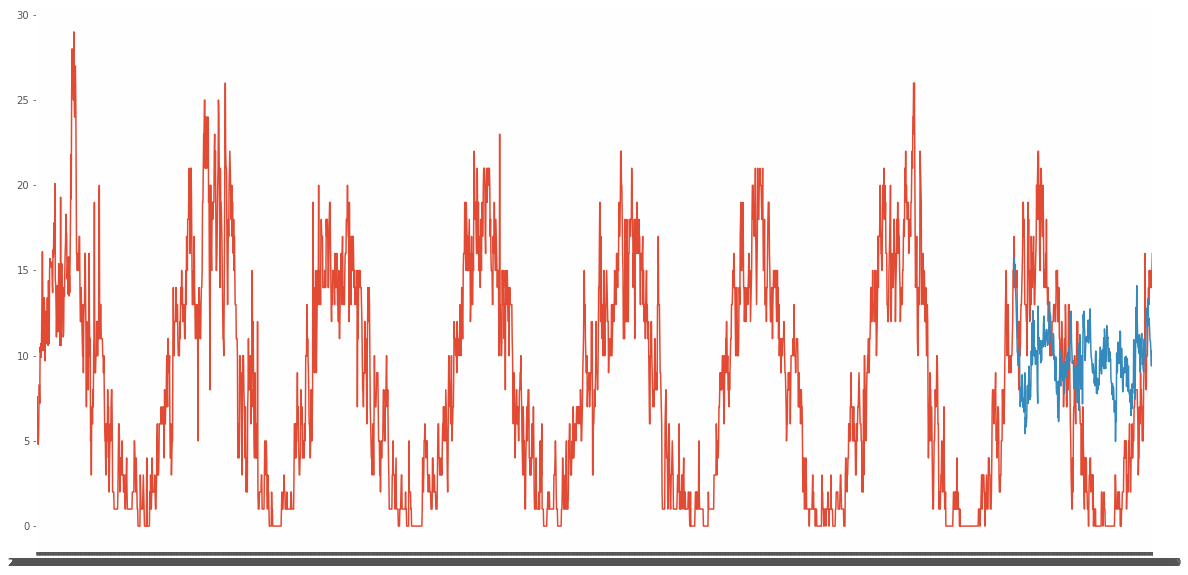

In [22]:
# plt.title('Month vs Passenger')
# plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['Gas_mxm'])
plt.plot(x,actual_predictions)
plt.show()

# Calculating the Coefficient of Determination

To know the accuracy of model

In [25]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(actual_predictions[-365: ], df['Gas_mxm'].iloc[-365:])
print(coefficient_of_dermination)

-12.903459167149293
